# Definition der Referenz für die Parametertests der Trackingverfahren

Eine Idee, um eine Referenz für die Parameter der Trackingverfahren zu haben, ist Beispiele zu nehmen und nur eine Box um ein "Objekt" zu verfolgen. 

In [2]:
import sys
import numpy as np
import pandas as pd
import xarray as xr

import glob
import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import object_tracking as ot
import tracking_common as tc

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
talos_home = "/vols/talos/home/stephan"
data_path = "{talos_home}/data".format(talos_home=talos_home)
track_data_path = "{dp}/radar_track/trackdata".format(dp=data_path)

Als nächstes lesen wir die Pfade aller möglichen manuellen Tracks ein und laden uns ein Beispiel.

In [4]:
track_paths = glob.glob("{tdp}/*.nc".format(tdp=track_data_path))

In [5]:
track_example = xr.open_dataset(track_paths[55])

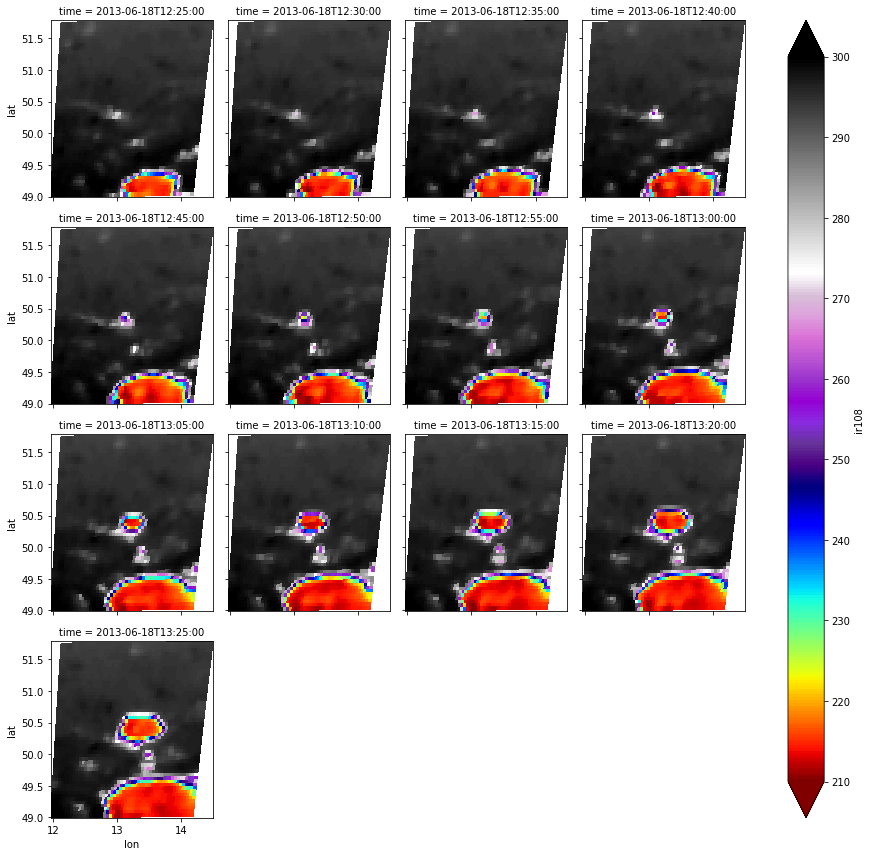

In [6]:
track_example.ir108.plot(x='lon',y='lat',col='time',col_wrap=4,cmap=emap,vmin=210,vmax=300)

## Hystereseschwellwert

Nun müssen wir irgendwie die konvektive Wolke in der Mitte des Ausschnittes isolieren. Das Hystereseschwellwertverfahren wäre einen Versuch wert.

In [6]:
ir_seg = ot.apply_hysteresis_threshold(-track_example.ir108[0],-280,-270)

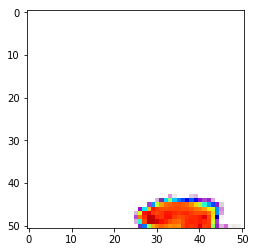

In [7]:
plt.imshow(np.ma.masked_where(ir_seg<1,track_example.ir108[0]),vmin=210,vmax=300,cmap=emap)

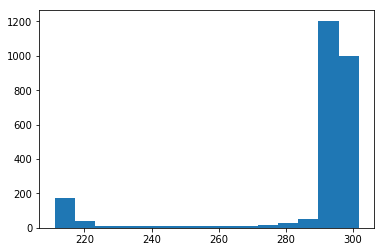

In [8]:
bd = plt.hist(track_example.ir108[7].data.ravel(),bins=15)

## Segmentierung mittels der NWCSAF-Wolkenmaske

Oder ein Versuch mit der Wolkenmase.

In [9]:
ir_seg = np.ma.masked_where(track_example.cma[0]<2,track_example.ir108[0])

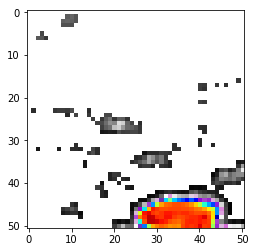

In [10]:
plt.imshow(ir_seg,vmin=210,vmax=300,cmap=emap)

## Filter und Watershed

Eine Möglichkeit wäre auch eine Kombination aus Wolkenmase, Maximumfilter, um die lokalen Maxima zu finden und diese dann als ein Anfangspunkt für eine Watershedsegmentierung zu benutzen.

Dafür benötigen wir noch ein paar Pakete.

In [76]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops

Dann suchen wir uns den CI-Zeitschritt aus.

In [19]:
it = 7

Und wählen nur die wolkigen Bereiche aus.

In [13]:
cloudy = np.ma.masked_where(track_example.cma[it]<2,track_example.ir108[it])

Dann glätten wir den Auschnitt mit einem Extremwertfilter, um dann die Extrema zu suchen.

In [14]:
cloudy_max = ndi.maximum_filter(np.max(cloudy)-cloudy,5)

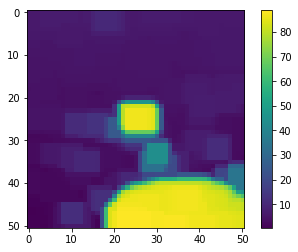

In [15]:
plt.imshow(cloudy_max)
plt.colorbar()

In [16]:
max_coordinates = peak_local_max(-cloudy,min_distance=3)

Da sollten wir mal einen Blick darauf werfen.

Text(0.5,1,u'IR 10,8 \xb5m, mit lokalen Minima\n2013-06-18 13:00:00 UTC')

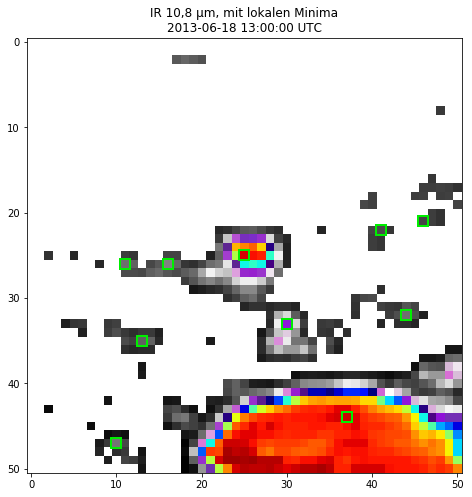

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(cloudy,vmin=210,vmax=300,cmap=emap)

for p in max_coordinates:
    ax.plot(p[1],p[0],markersize=10,mew=2,color='#00ee00',marker='s',markerfacecolor='none')
    
ax.set_title(u"IR 10,8 µm, mit lokalen Minima\n{} UTC".format(pd.to_datetime(str(track_example.time[it].data)).replace(tzinfo=None)))

Als nächstes erstellen wir eine neue Matrix mit den lokalen Minima, um sie für die Wateshedsegmentierung als Startpunkte zu benutzen.

In [24]:
markers = np.zeros_like(track_example.ir108[it])

In [25]:
for i,p in enumerate(max_coordinates):
    markers[p[0],p[1]] = i+1

Text(0.5,1,u'Markierungen\n2013-06-18 13:00:00 UTC')

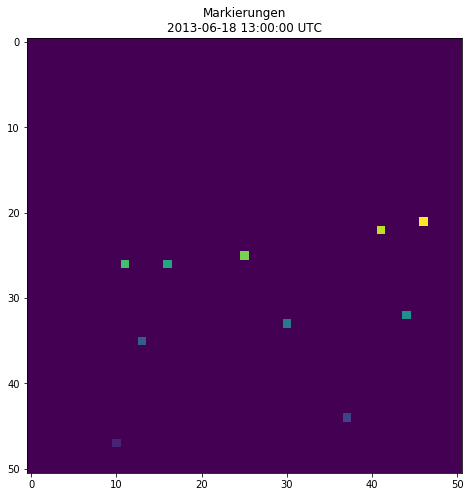

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(markers)
   
ax.set_title(u"Markierungen\n{} UTC".format(pd.to_datetime(str(track_example.time[it].data)).replace(tzinfo=None)))

Dann können wir die Segmentierung durchführen und uns ansehen.

In [29]:
labels = watershed(cloudy, markers, mask=~cloudy.mask)

Text(0.5,1,u'segmentierter IR 10,8 \xb5m\n2013-06-18 13:00:00 UTC')

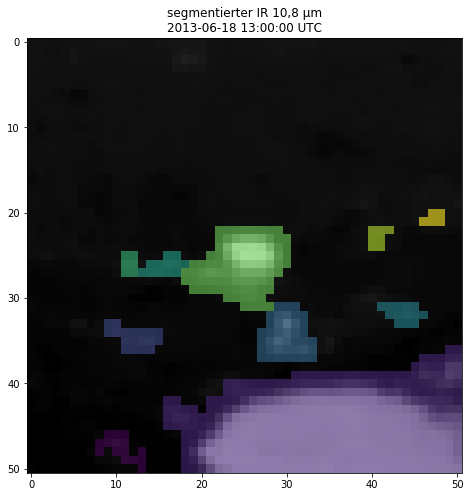

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(track_example.ir108[7].data,vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(labels,1),alpha=0.6)
ax.set_title(u"segmentierter IR 10,8 µm\n{} UTC".format(pd.to_datetime(str(track_example.time[it].data)).replace(tzinfo=None)))

Das scheint soweit vernünftig zu funktionieren. Allerdings werden Wolkenbereiche, die wahrscheinlich zu einem Objekt gehören, getrennt. Da sollte eine Glättung des Eingangsfeldes weiterhelfen. Eine Möglichkeit ist der bilaterale Filter, da er es ermöglicht, die Intensität und die Rauminformation getrennt zu glätten. Da wir die Intensität gerne stärker gelättet haben wollen als, die Rauminformationen, um die Segmentierung stabiler zu gestalten, setzten wir die Glättung für die Intensitöt auf einen sehr hohen Wert und versuchen die räumliche Glättung ganz wegzulassen.

Dafür benötigen wir allerdings noch das Paket cv2.

In [8]:
import cv2

In [47]:
neighbourhood = np.arange(5,50,5)
colour_smoothing = np.arange(25,250,25)

In [48]:
smoothed_ir = {n:{c:{} for c in colour_smoothing} for n in neighbourhood}

In [49]:
for n in neighbourhood:
    for c in colour_smoothing:
        smoothed_ir[n][c] = cv2.bilateralFilter(cloudy.astype("float32"),n,c,1)

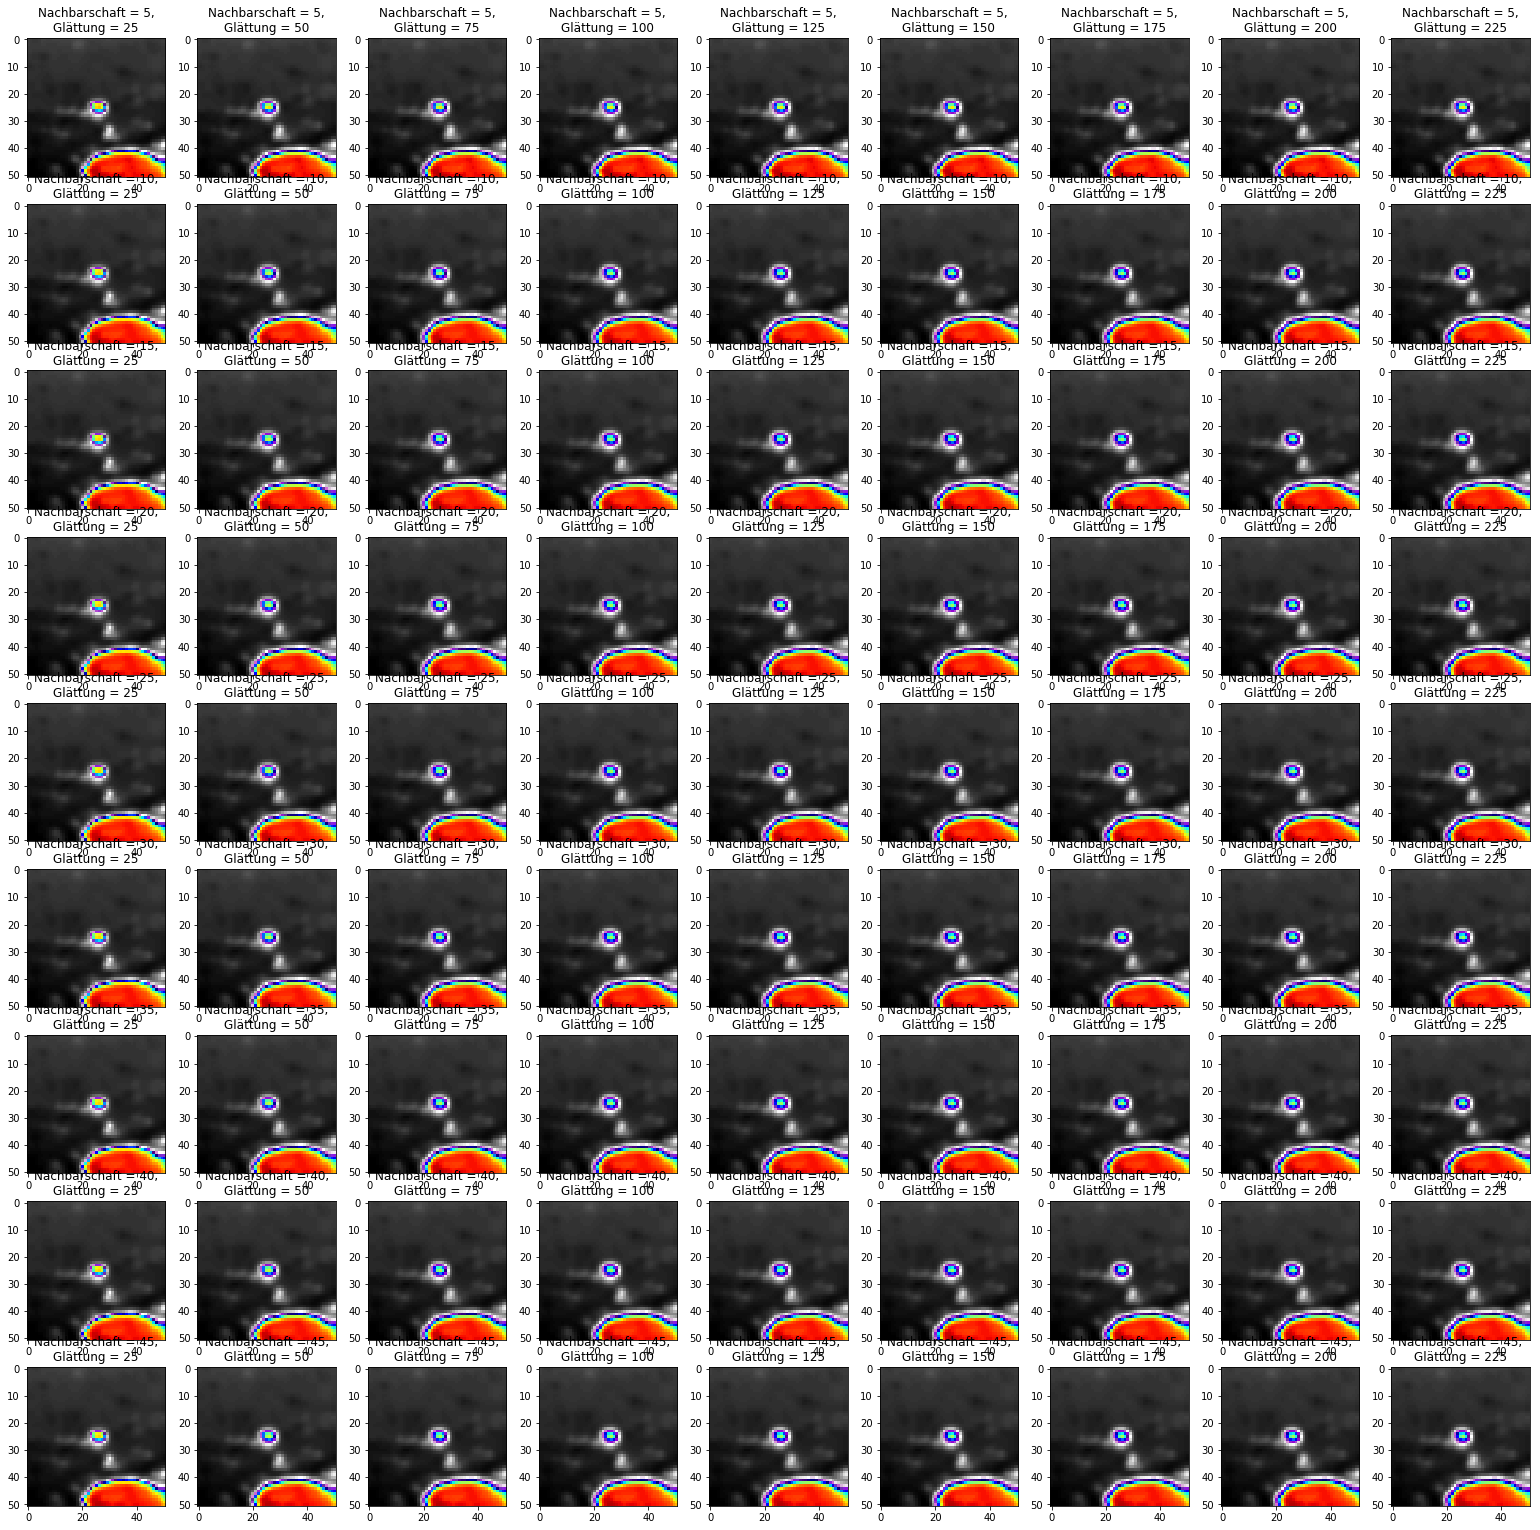

In [51]:
i = 0
fig,ax = plt.subplots(len(neighbourhood),
                      len(colour_smoothing),
                      figsize=(len(neighbourhood)*3,
                               len(colour_smoothing)*3))
axs=ax.ravel()

for n in neighbourhood:
    for c in colour_smoothing:
        axs[i].imshow(smoothed_ir[n][c],vmin=210,vmax=300,cmap=emap)
        axs[i].set_title(u"Nachbarschaft = {n},\nGlättung = {g}".format(n=n,g=c))
        
        i +=1

Das sieht ganz so aus, als wären die Unterschiede ab einer Nachbarschaft von 20 und einer Glättung von 50 nicht mehr besonders groß. Also nehmen wir erstmal diese Werte.

In [72]:
ir108_segmented = []

for i,ir in enumerate(track_example.ir108.data):
    ir = cv2.bilateralFilter(ir.astype("float32"),15,50,1)
    ir_masked = np.ma.masked_where(track_example.cma[i].data<2,ir)
    max_coordinates = peak_local_max(-ir_masked,min_distance=4)
    markers = np.zeros_like(ir_masked)
    
    for j,p in enumerate(max_coordinates):
        markers[p[0],p[1]] = j+1

    labels = watershed(ir_masked, markers, mask=~ir_masked.mask)
    
    ir108_segmented.append(labels)

Dann sehen wir uns das Ergebnis mal an.

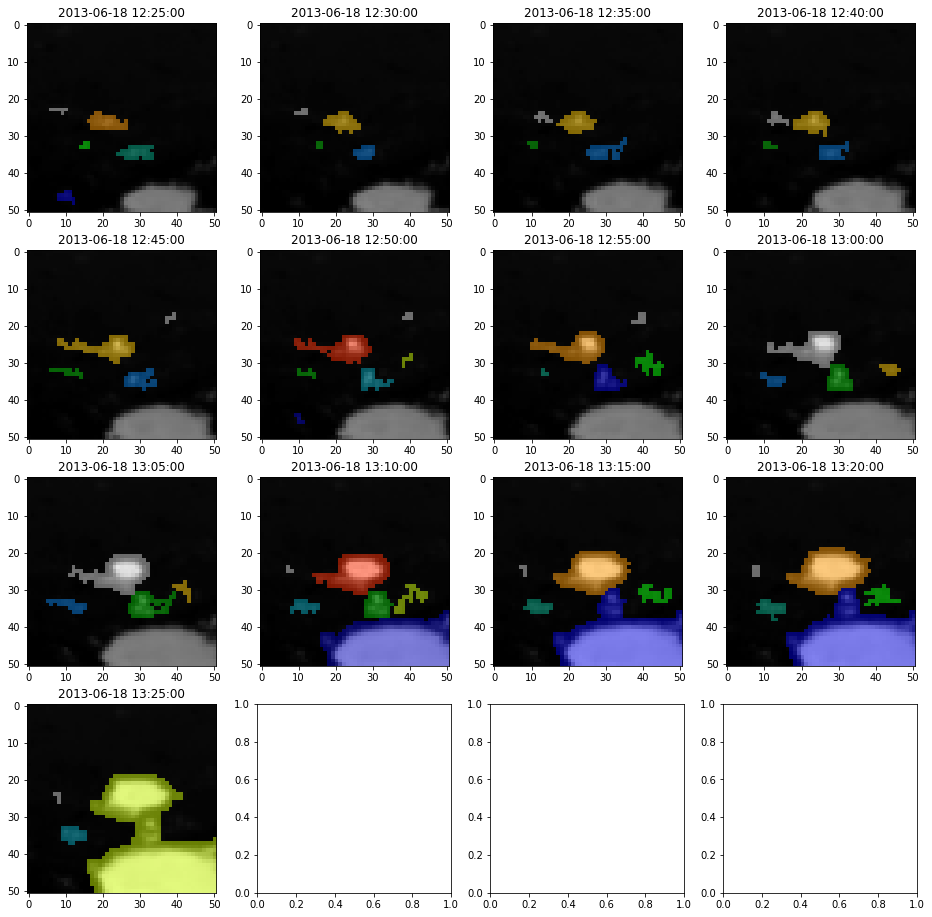

In [73]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,ir in enumerate(ir108_segmented):
    axs[i].imshow(track_example.ir108[i].data,vmin=210,vmax=300, cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(ir,0),alpha=0.5,cmap='nipy_spectral')
    axs[i].set_title(pd.to_datetime(str(track_example.time[i].data)).replace(tzinfo=None))

Das sieht ziemlich gut aus. Es ist möglich die Wolken im erten Zeitschritt gut zu trennen und erst im letzten Zeitschritt verschmelzen die meisten Wolken zu einem Objekt.

Als nächstes bestimmen wir die Umgebungsbegrenzungen der markierten Bereiche.

In [78]:
ir_bboxes = {i:{} for i in xrange(len(ir108_segmented))}

for i,l in enumerate(ir108_segmented):
    props = regionprops(l)
    
    for j,obj in enumerate(props):
        ir_bboxes[i][j] = obj['bbox']

## Segmentierung des HRV-Kanals

Jetzt versuchen wir das Ganze nocheinmal mit dem HRV-Kanal und hoffen, dass es auch für ihn funktioniert.

In [96]:
from analysis_tools import make_hrv_upscaling as mhu

cma_h = np.array([mhu.make_hrv_upscaling(c) for c in track_example.cma.data])

In [130]:
hrv_segmented = []

for i,h in enumerate(track_example.hrv.data):
    h = cv2.bilateralFilter(h.astype("float32"),15,25,1)
    h_masked = np.ma.masked_where(cma_h[i]<2,h)
    max_coordinates = peak_local_max(h_masked,min_distance=4)
    
    markers = np.zeros_like(h_masked)
    
    for j,p in enumerate(max_coordinates):
        markers[p[0],p[1]] = j+1

    labels = watershed(h_masked, markers, mask=~h_masked.mask)
    
    hrv_segmented.append(labels)

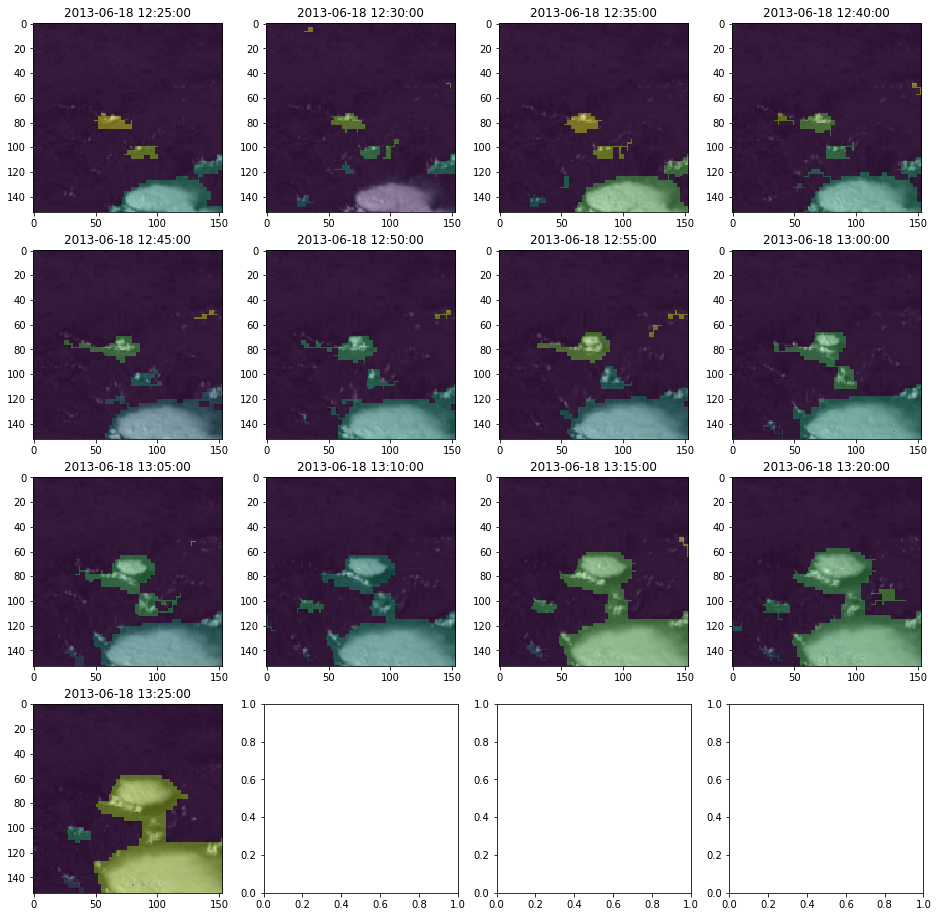

In [131]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(hrv_segmented):
    axs[i].imshow(np.clip(track_example.hrv[i].data,0,1),vmin=0,vmax=1, cmap='gray')
    axs[i].imshow(np.ma.masked_less(h,0),alpha=0.4)
    axs[i].set_title(pd.to_datetime(str(track_example.time[i].data)).replace(tzinfo=None))

Das funktioniert auch, aber die grobe Auflösung der Wolkenmaske macht Probleme. Vielleicht ist der Reflektanzwert von 0,2 oder 0,3, wie in der CI-Evaluierung, besser geeignet.

In [132]:
hrv_segmented = []

for i,h in enumerate(track_example.hrv.data):
    h = cv2.bilateralFilter(h.astype("float32"),15,25,1)
    h_masked = np.ma.masked_less(h,0.2)
    max_coordinates = peak_local_max(h_masked,min_distance=4)
    
    markers = np.zeros_like(h_masked)
    
    for j,p in enumerate(max_coordinates):
        markers[p[0],p[1]] = j+1

    labels = watershed(h_masked, markers, mask=~h_masked.mask)
    
    hrv_segmented.append(labels)

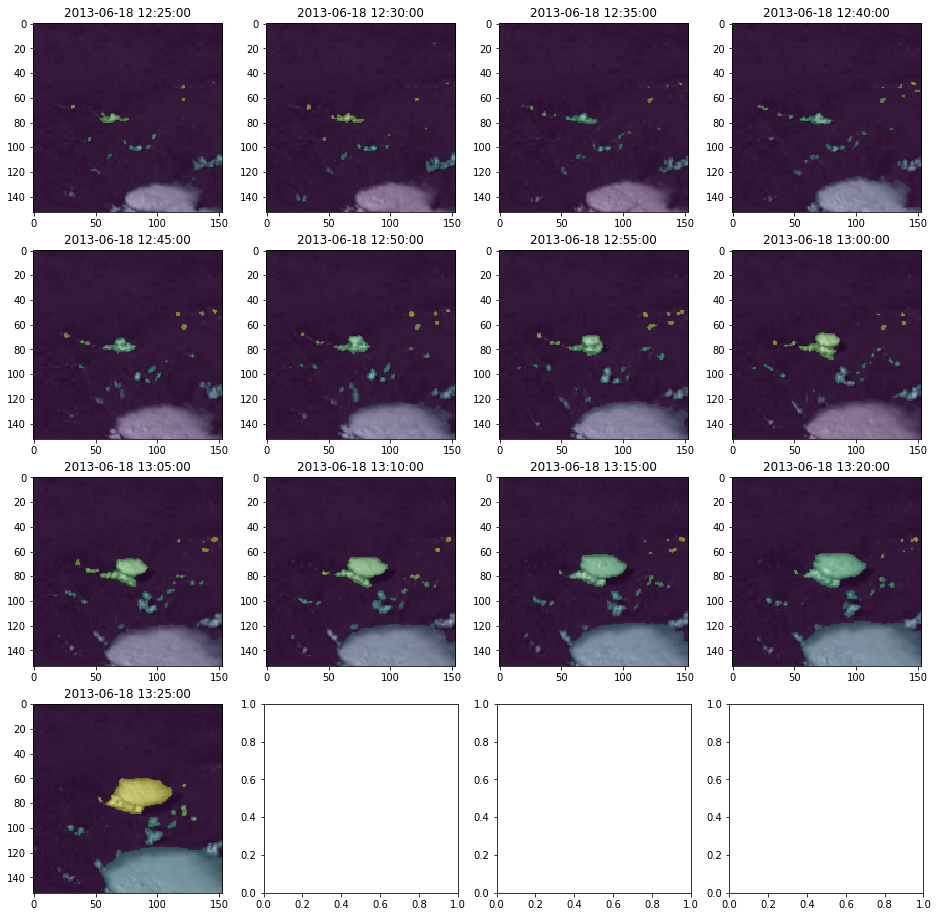

In [133]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(hrv_segmented):
    axs[i].imshow(np.clip(track_example.hrv[i].data,0,1),vmin=0,vmax=1, cmap='gray')
    axs[i].imshow(np.ma.masked_less(h,0),alpha=0.4)
    axs[i].set_title(pd.to_datetime(str(track_example.time[i].data)).replace(tzinfo=None))

Das sieht deutlich besser aus und erlaubt eine viel bessere Trennung der Wolken als die Segmentierung des IR-10,8-µm-Kanals.

Dann packen wir das ganze mal in eine Funktion.

In [189]:
def smooth_watershed(field,cloud_mask=None,threshold=0.2,smoothing_neighbourhood=15,intensity_smoothing=25,
                     spatial_smoothing=1,extreme_type='max',extrema_separation=4):
    """
    Segments a given field using a bilateral filter and watershed segmentation.
    
    Inputs:
    -------
        * field: numpy array, 2d or 3d
            field to be segmented
        * cloud_mask: numpy array, 2d or 3d, default=None
            NWCSAF cloud mask to use for the separation of foreground and background, if not given a 
            threshold is used
        * threshold: float, default=0.2
            threshold to use for the separation of foreground and background, 
        * smoothing_neighbourhood: int
            parameter of the bilateral filter, neighbourhood to smooth for
        * intensity_smoothing: int
            parameter of the bilateral filter, strength of the smoothing in intesity space
        * spatial_smoothing: int
            parameter of the bilateral filter, strength of the smoothing in spatial space
        * extreme_type: str
            type of extremes to look for, minima (min) or maxmia (mx)
        * extrema_separation: int
            minimum distance between two extrema used a starting points for the watershed segmentation
    Output:
    -------
        * segmented_field: numpy array, 2d or 3d
    """
    from cv2 import bilateralFilter
    from skimage.feature import peak_local_max
    from skimage.morphology import watershed
    
    valid_extremes = ['min','max']
    
    # smooth field
    field_smoothed = bilateralFilter(field.astype("float32"),
                                     smoothing_neighbourhood,
                                     intensity_smoothing,
                                     spatial_smoothing)
    
    # determine foreground and background
    if np.any(cloud_mask):
        field_masked = np.ma.masked_where(cloud_mask<2,field)
        
        if extreme_type in valid_extremes:
            if extreme_type == 'max':
                extreme_coordinates = peak_local_max(field_masked,min_distance=extrema_separation)
                
            elif extreme_type == 'min':
                extreme_coordinates = peak_local_max(-field_masked,min_distance=extrema_separation)
            else:    
                print("{} ist not a valid extreme type. Only 'min' and 'max' are valid.".format(extreme_type))
                return
    else:
        if extreme_type in valid_extremes:
            if extreme_type == 'max':
                # detect local maxima
                field_masked = np.ma.masked_less(field_smoothed,threshold)

                extreme_coordinates = peak_local_max(field_masked,min_distance=extrema_separation)
                
            elif extreme_type == 'min':
                # detect local minima
                field_masked = np.ma.masked_greater(field_smoothed,threshold)
                
                extreme_coordinates = peak_local_max(-field_masked,min_distance=extrema_separation)
            else:    
                print("{} ist not a valid extreme type. Only 'min' and 'max' are valid.".format(extreme_type))
                return
            
    # create array with markers for watershed segmentation
    markers = np.zeros_like(field_masked)
    
    for j,p in enumerate(extreme_coordinates):
        markers[p[0],p[1]] = j+1

    # perform watershed segmentation
    segmented_field = watershed(field_masked, markers, mask=~field_masked.mask)
    
    return segmented_field

In [144]:
test_hrv = smooth_watershed(track_example.hrv[7].data)

In [190]:
#test_ir = smooth_watershed(-track_example.ir108[7].data,track_example.cma[7].data,0,25,10,1,3)
test_ir = smooth_watershed(track_example.ir108[7].data,track_example.cma[7].data,240,25,10,1,'min',3)

Text(0.5,1,u'IR 10,8 \xb5m segmentiert')

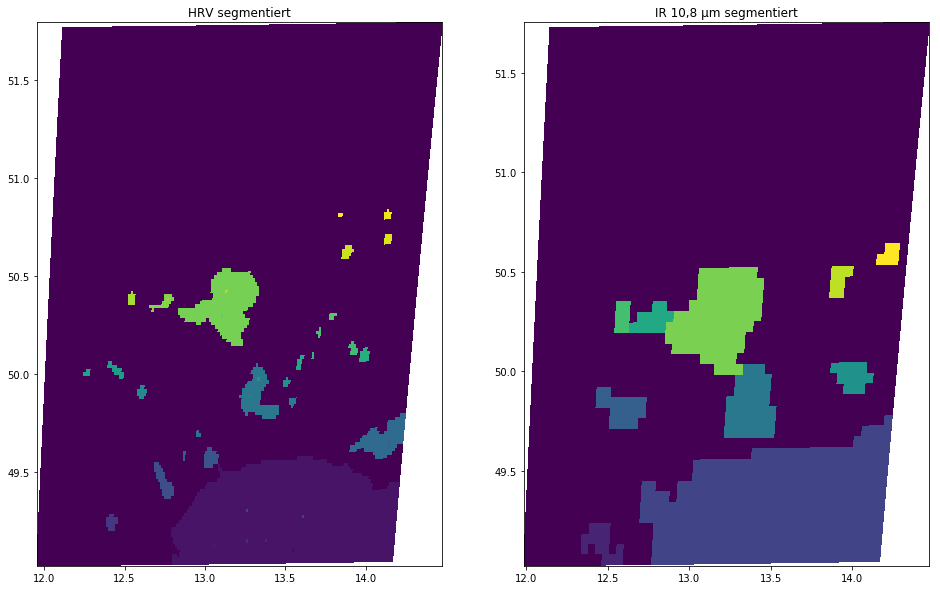

In [191]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].pcolormesh(track_example.hlon.data,track_example.hlat.data,test_hrv)
ax[0].set_title(u"HRV segmentiert")
ax[1].pcolormesh(track_example.lon.data,track_example.lat.data,test_ir)
ax[1].set_title(u"IR 10,8 µm segmentiert")

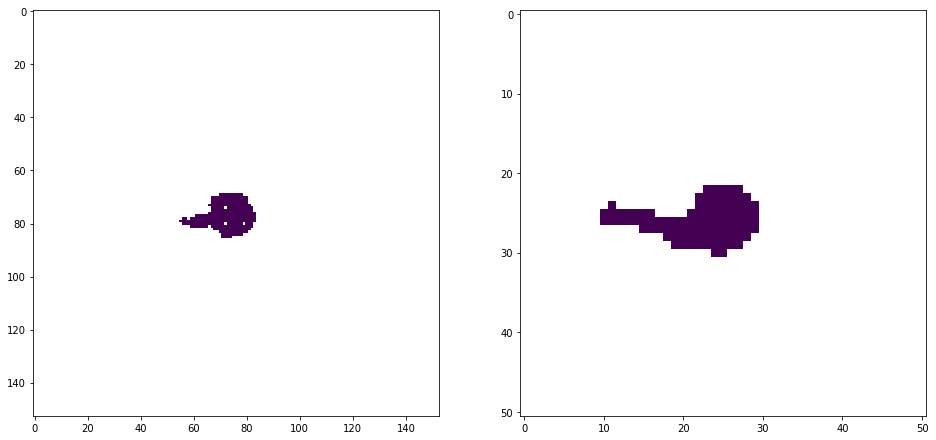

In [222]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(np.ma.masked_not_equal(hrv_segmented[6],wanted_object_hrv))
ax[1].imshow(np.ma.masked_not_equal(ir108_segmented[6],wanted_object_ir108))

## Segmentierung mittels morphologischer Rekonstruktion

Eine weitere Variante ist die Segmentierung mittels morphologischer Rekonstruktion. Dafür suchen wir in den HRV-Daten nach Gipfeln und in den IR-10,8-µm-Saten nach Löchern.

In [9]:
hrv_peaks = np.array([cv2.bilateralFilter(ot.find_peaks(h).astype("float32"),15,75,1)
                      for h in track_example.hrv.data])
ir_holes = np.array([ot.find_holes(i)
                     for i in track_example.ir108.data])

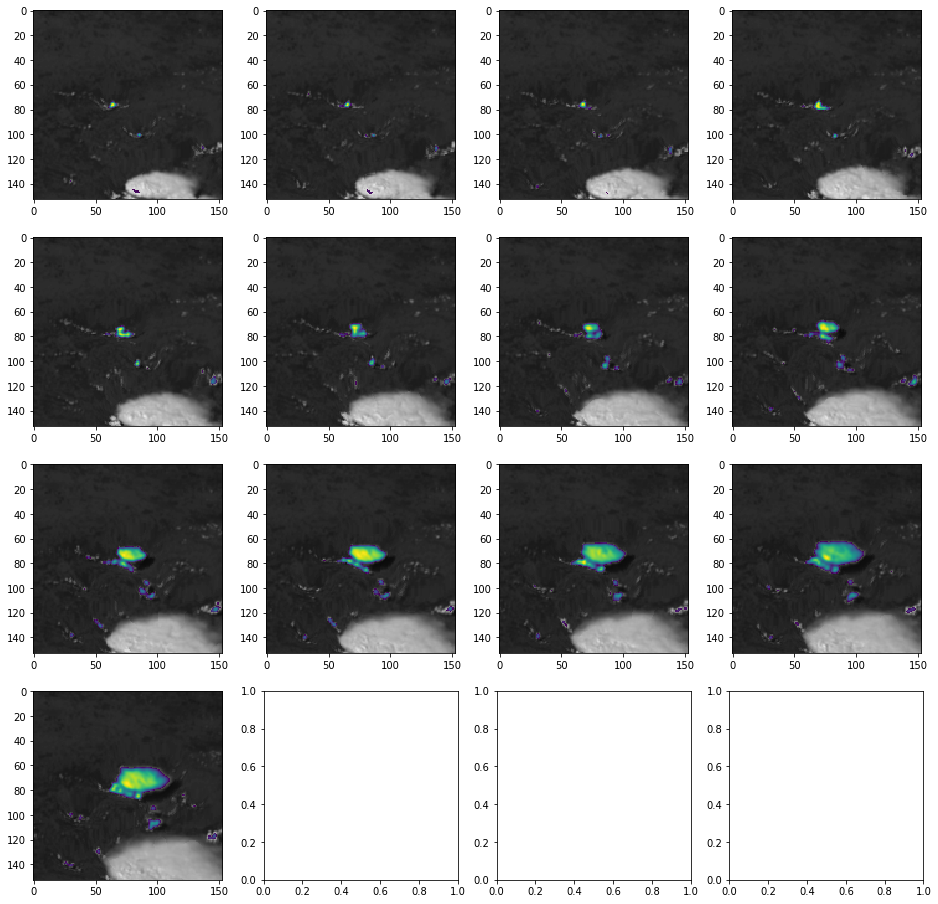

In [10]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,h in enumerate(hrv_peaks):
    axs[i].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(np.ma.masked_where(h<=0.15,h))

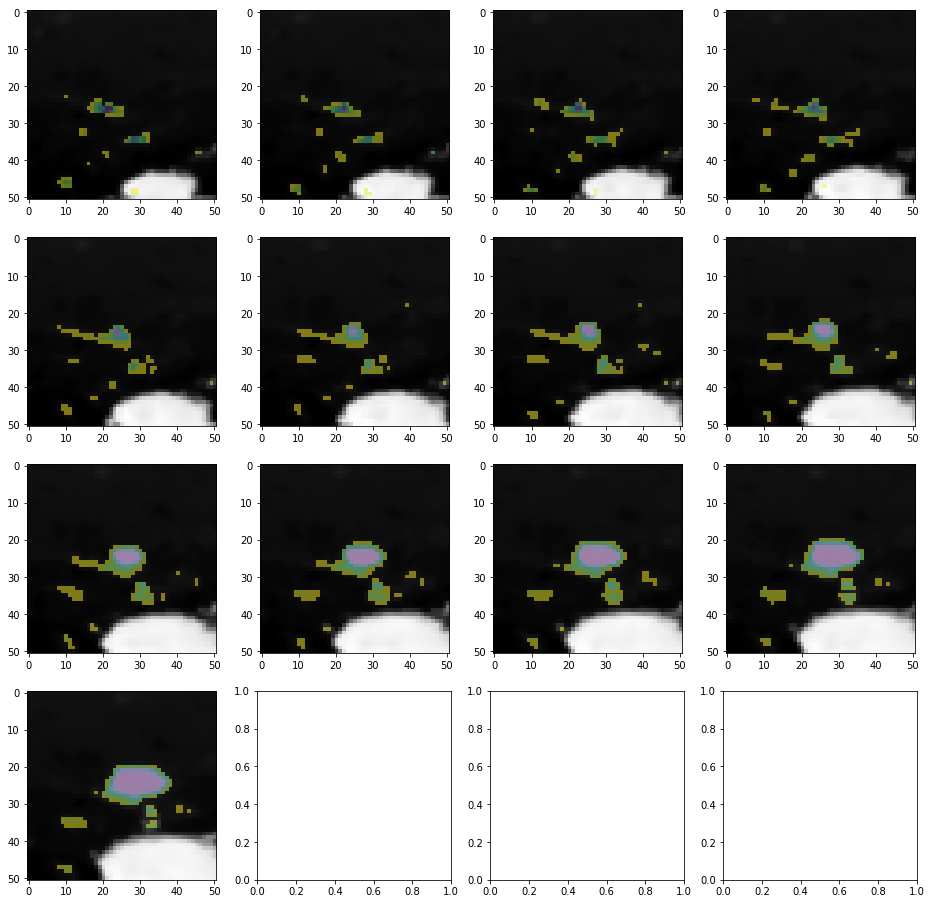

In [11]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,h in enumerate(ir_holes):
    axs[i].imshow(track_example.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_where(h>=-2,h),alpha=0.5)

Es sieht so aus, als wären 0,15 für den HRV-Kanal und -2 für den IR-10,8-µm-Kanal ganz gute Schwellwerte.

In [12]:
from scipy import ndimage as ndi

In [13]:
hrv_peaks_masked = []
ir_holes_masked = []


for i, h in enumerate(hrv_peaks):
    dummy = np.zeros_like(h)
    dummy[np.where(h>0.15)] = 1
    obj,nlabel = ndi.label(dummy)
    
    hrv_peaks_masked.append(obj)
    
    dummy = np.zeros_like(ir_holes[i])
    dummy[np.where(ir_holes[i]<-2)] = 1
    
    obj,nlabel = ndi.label(dummy)
    
    ir_holes_masked.append(obj)    

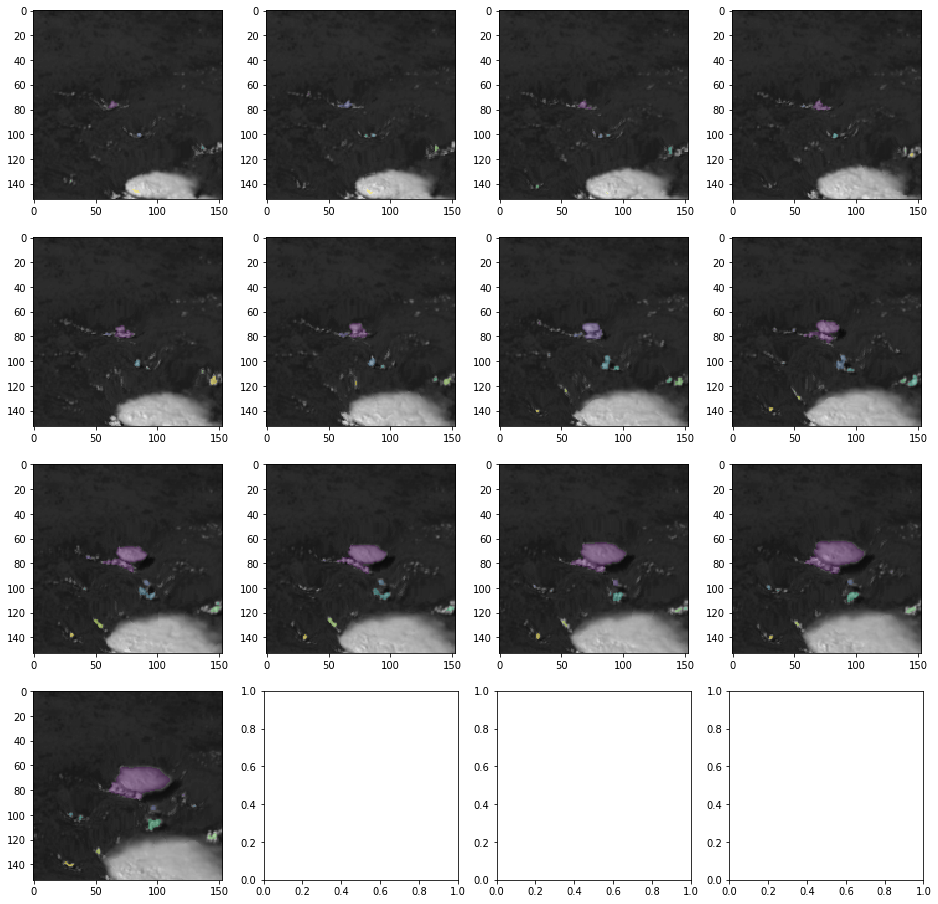

In [14]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,h in enumerate(hrv_peaks_masked):
    axs[i].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(np.ma.masked_less(h,1),alpha=0.4)

In [15]:
wanted_id = []

for o in np.unique(ir_holes_masked[6]):
    idx = np.where(ir_holes_masked[6]==o)
    
    if 51//2 in idx[0] and 51//2 in idx[1]:
        wanted_id = o
    else:
        continue

In [16]:
wanted_id

2

In [17]:
slice_x, slice_y = ndi.find_objects(ir_holes_masked[6]==wanted_id)[0]
roi = track_example.ir108.data[6][slice_x, slice_y]

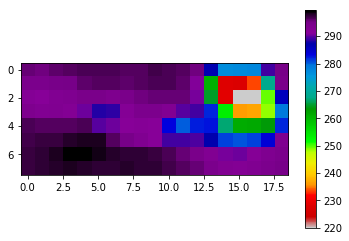

In [18]:
plt.imshow(roi,cmap='nipy_spectral_r')
plt.colorbar()

In [19]:
print slice_x, slice_y

slice(23L, 31L, None) slice(10L, 29L, None)


In [20]:
connections,objects = ot.generate_graph_from_components(ir_holes_masked,np.arange(0,14),1)

In [21]:
object_id = '6_{:04d}'.format(wanted_id)

wanted_object_graph = []

for obj in objects:
    if object_id in obj.nodes():
        wanted_object_graph = obj
    else:
        continue

In [22]:
object_id

'6_0002'

In [23]:
wanted_object_graph.nodes()

NodeView(('8_0001', '3_0002', '3_0003', '5_0002', '1_0002', '6_0002', '1_0001', '11_0002', '11_0001', '10_0001', '10_0002', '2_0002', '4_0002', '12_0001', '0_0002', '9_0001', '7_0001', '2_0001'))

In [24]:
import networkx as nx

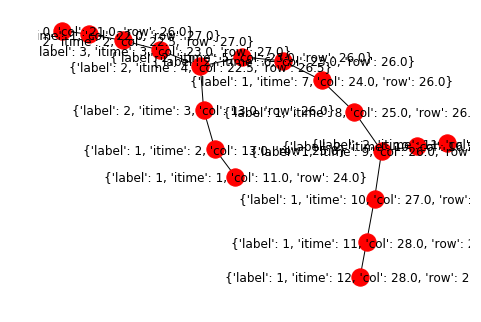

In [25]:
nx.draw(wanted_object_graph,labels=wanted_object_graph.nodes())

In [26]:
graph_time = ot.sort_graph_by_timesteps(wanted_object_graph)

In [27]:
print(graph_time)

{0: ['0_0002'], 1: ['1_0002', '1_0001'], 2: ['2_0002', '2_0001'], 3: ['3_0002', '3_0003'], 4: ['4_0002'], 5: ['5_0002'], 6: ['6_0002'], 7: ['7_0001'], 8: ['8_0001'], 9: ['9_0001'], 10: ['10_0001', '10_0002'], 11: ['11_0002', '11_0001'], 12: ['12_0001']}


Leider gibt es bei mehreren Zeitschritten mehrere Objekte. Ideal wäre nur ein Objekt pro Zeitschritt. Ein Ansatz wäre, nur das größte Objekt zu speichern.

In [28]:
object_track = []

for t in graph_time.keys():
    elements = []
    sizes = []
    for element in graph_time[t]:
        obj_id = int(element.split("_")[1])
        
        obj_size = len(np.where(ir_holes_masked[t]==obj_id)[0])
        
        sizes.append(obj_size)
        elements.append(element)
        
    max_id = np.where(np.array(sizes)== np.max(np.array(sizes)))
    
    object_track.append(elements[max_id[0][0]])

In [29]:
object_track

['0_0002',
 '1_0002',
 '2_0002',
 '3_0003',
 '4_0002',
 '5_0002',
 '6_0002',
 '7_0001',
 '8_0001',
 '9_0001',
 '10_0001',
 '11_0001',
 '12_0001']

In [30]:
bboxes = []

for element in object_track:
    time_id = int(element.split("_")[0])
    obj_id = int(element.split("_")[1])
    bbox = ndi.find_objects(ir_holes_masked[time_id]==obj_id)[0]

    bboxes.append(bbox)

In [31]:
bboxes

[(slice(24L, 29L, None), slice(16L, 26L, None)),
 (slice(25L, 29L, None), slice(17L, 27L, None)),
 (slice(24L, 30L, None), slice(18L, 27L, None)),
 (slice(24L, 30L, None), slice(18L, 27L, None)),
 (slice(24L, 31L, None), slice(9L, 28L, None)),
 (slice(23L, 30L, None), slice(10L, 29L, None)),
 (slice(23L, 31L, None), slice(10L, 29L, None)),
 (slice(22L, 31L, None), slice(11L, 30L, None)),
 (slice(22L, 31L, None), slice(12L, 32L, None)),
 (slice(21L, 31L, None), slice(15L, 34L, None)),
 (slice(21L, 31L, None), slice(19L, 36L, None)),
 (slice(20L, 31L, None), slice(20L, 37L, None)),
 (slice(20L, 31L, None), slice(20L, 39L, None))]

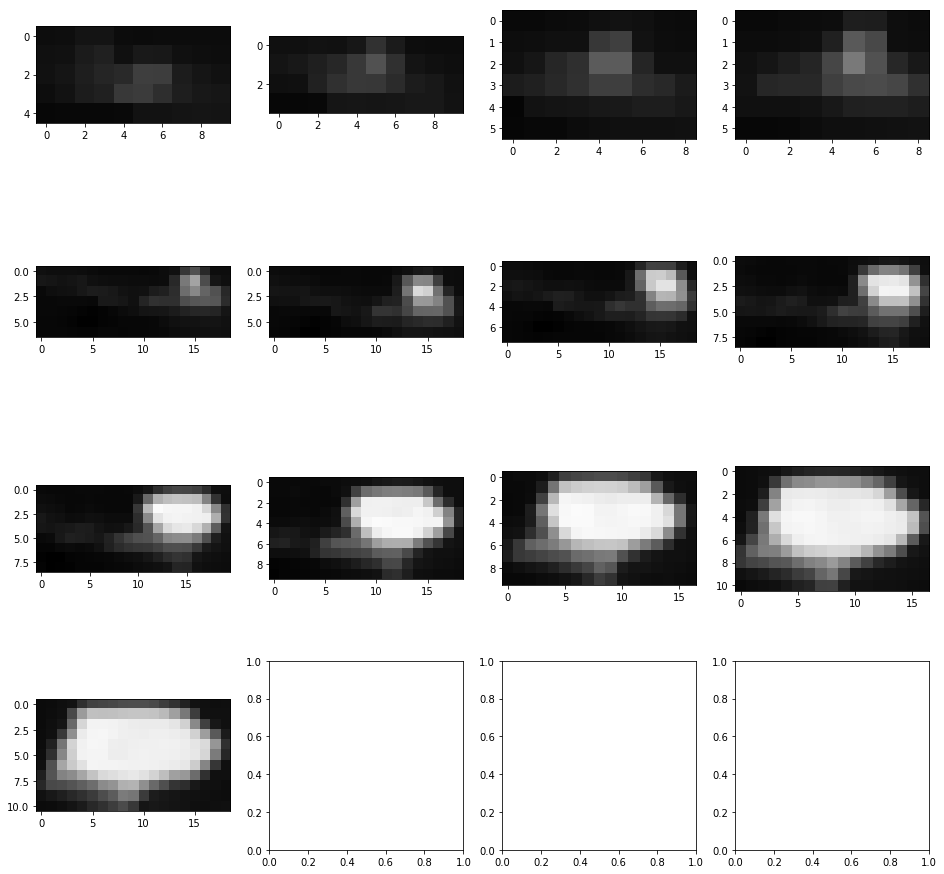

In [32]:
cutouts = []
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i,bx in enumerate(bboxes):
    cutout = track_example.ir108.data[i][bx[0],bx[1]]
    
    axs[i].imshow(cutout,vmin=210,vmax=300, cmap='gray_r')

Das funktioniert gut, könnte aber problematisch sein, wenn ein größeres Objekt mit einem kleineren verschmilzt. Vielleicht ist die Überlappgröße etwas robuster. Als nächstes probieren wir das mal aus.

In [36]:
t_back = np.arange(5,-1,-1)
t_fwd = np.arange(7,13,1)

In [37]:
start_points = np.where(ir_holes_masked[6].ravel()==wanted_id)

points_prev = start_points
prev_id = object_id
obj_back = [object_id]
obj_fwd = []

In [39]:
for i,t in enumerate(t_back):
    points_prev = np.where(ir_holes_masked[t_back[i-1]].ravel() == int(prev_id.split("_")[1]))
    if len(graph_time[t]) >1 :
        overlap_sizes = []
        elements = []
        
        for element in graph_time[t]:
            obj_id = int(element.split("_")[1])

            obj_points = np.where(ir_holes_masked[t].ravel()==obj_id)[0]

            overlap = np.intersect1d(points_prev,obj_points)

            overlap_sizes.append(len(overlap))
            elements.append(element)

        overlap_sizes = np.array(overlap_sizes)
        elements = np.array(elements)

        max_id = np.where(overlap_sizes == overlap_sizes.max())
        wanted_id = np.array(elements)[max_id]
        
        prev_id = wanted_id[0]
        obj_back.append(prev_id)
    else:
        prev_id = graph_time[t][0]
        obj_back.append(graph_time[t][0])

In [40]:
points_prev = start_points
prev_id = object_id

In [41]:
for i,t in enumerate(t_fwd):
    points_prev = np.where(ir_holes_masked[t_fwd[i-1]].ravel() == int(prev_id.split("_")[1]))
    if len(graph_time[t]) >1 :
        overlap_sizes = []
        elements = []
        
        for element in graph_time[t]:
            obj_id = int(element.split("_")[1])

            obj_points = np.where(ir_holes_masked[t].ravel()==obj_id)[0]

            overlap = np.intersect1d(points_prev,obj_points)

            overlap_sizes.append(len(overlap))
            elements.append(element)

        overlap_sizes = np.array(overlap_sizes)
        elements = np.array(elements)

        max_id = np.where(overlap_sizes == overlap_sizes.max())

        wanted_id = elements[max_id]
        obj_fwd.append(wanted_id[0])
        prev_id = wanted_id[0]
    else:
        prev_id = graph_time[t][0]
        obj_fwd.append(prev_id)

In [42]:
wanted_track = obj_back[::-1] + obj_fwd

In [43]:
wanted_track

['0_0002',
 '1_0002',
 '2_0002',
 '3_0003',
 '4_0002',
 '5_0002',
 '6_0002',
 '7_0001',
 '8_0001',
 '9_0001',
 '10_0001',
 '11_0001',
 '12_0001']

In [45]:
bboxes = {t:[] for t in np.arange(0,13,1)}

for element in wanted_track:
    time_id = int(element.split("_")[0])
    obj_id = int(element.split("_")[1])
    bbox = ndi.find_objects(ir_holes_masked[time_id]==obj_id)[0]

    bboxes[time_id] = bbox

In [46]:
bboxes

{0: (slice(24L, 29L, None), slice(16L, 26L, None)),
 1: (slice(25L, 29L, None), slice(17L, 27L, None)),
 2: (slice(24L, 30L, None), slice(18L, 27L, None)),
 3: (slice(24L, 30L, None), slice(18L, 27L, None)),
 4: (slice(24L, 31L, None), slice(9L, 28L, None)),
 5: (slice(23L, 30L, None), slice(10L, 29L, None)),
 6: (slice(23L, 31L, None), slice(10L, 29L, None)),
 7: (slice(22L, 31L, None), slice(11L, 30L, None)),
 8: (slice(22L, 31L, None), slice(12L, 32L, None)),
 9: (slice(21L, 31L, None), slice(15L, 34L, None)),
 10: (slice(21L, 31L, None), slice(19L, 36L, None)),
 11: (slice(20L, 31L, None), slice(20L, 37L, None)),
 12: (slice(20L, 31L, None), slice(20L, 39L, None))}

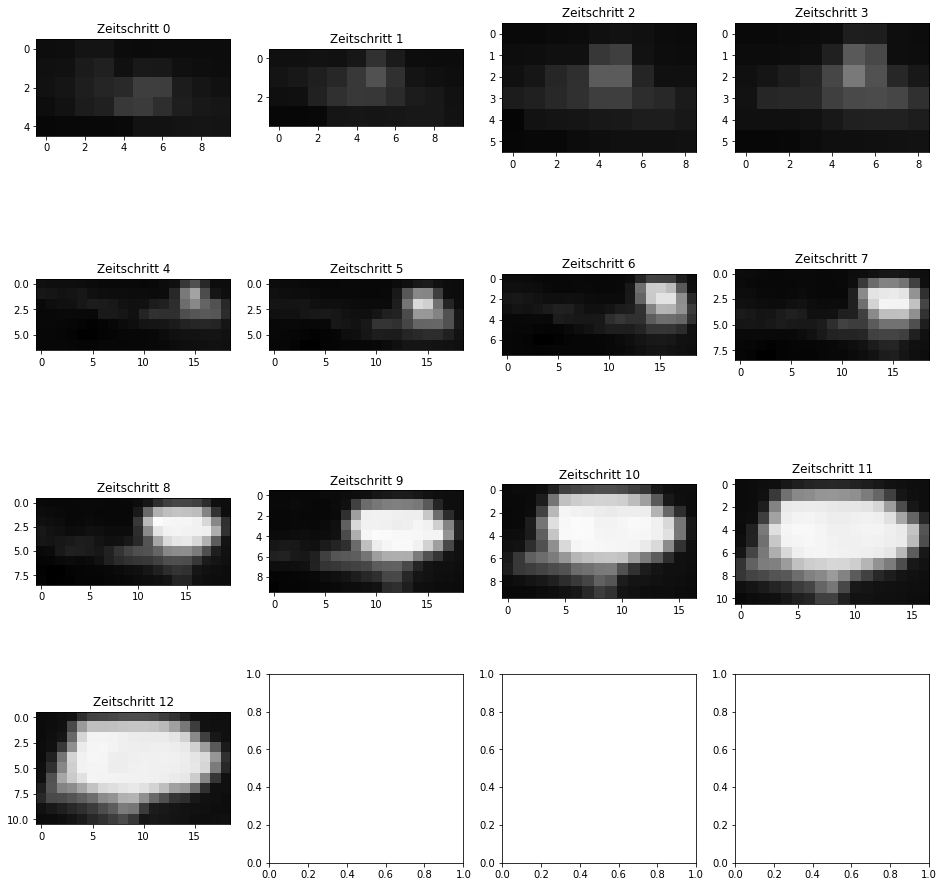

In [47]:
cutouts = []
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i in bboxes.keys():
    cutout = track_example.ir108.data[i][bboxes[i][0],bboxes[i][1]]
    
    axs[i].imshow(cutout,vmin=210,vmax=300, cmap='gray_r')
    axs[i].set_title(u"Zeitschritt {}".format(i))

OK, das Ergebnis ist identisch mit dem der Objektgröße. Als nächstes müssen wir die Boxen nur noch speichern.

In [48]:
times = np.arange(-30,35,5)
itimes = np.arange(0,13)

col_min = []
col_max = []
row_min = []
row_max = []

for t_idx in bboxes.keys():
    bbox = bboxes[t_idx]
    col_min.append(bbox[0].start)
    col_max.append(bbox[0].stop)
    
    row_min.append(bbox[1].start)
    row_max.append(bbox[1].stop)

In [326]:
bbox_df = pd.DataFrame({'time':times,'col_min':col_min,'col_max':col_max,
                        'row_min':row_min,'row_max':row_max})

In [327]:
track_paths[55]

'/vols/talos/home/stephan/data/radar_track/trackdata/haci_trackdata_20130618_88.nc'

In [328]:
track_id = "{}_{}".format(track_paths[55].split("/")[-1].split(".")[0].split("_")[-2],
                          track_paths[55].split("/")[-1].split(".")[0].split("_")[-1])

In [329]:
bbox_df.to_csv("/vols/talos/home/stephan/proj/2019-01_trackingstudie/data/bboxes/bbox_{}.csv".format(track_id))

In [162]:
reload(ot)

<module 'object_tracking' from '/vols/talos/home/stephan/utils/tracking/object_tracking.py'>

In [96]:
object_track = ot.extract_main_graph_from_complex(ir_holes_masked, graph_time, method='o')

[ 7  8  9 10 11 12]
t = 7, i = 0
6
t = 8, i = 1
7
t = 9, i = 2
8
t = 10, i = 3
9
t = 11, i = 4
10
t = 12, i = 5
11


In [97]:
object_track

['0_0002',
 '1_0002',
 '2_0002',
 '3_0003',
 '4_0002',
 '5_0002',
 '6_0002',
 '7_0001',
 '8_0001',
 '9_0001',
 '10_0001',
 '11_0001',
 '12_0001']

In [98]:
bboxes = ot.get_bounding_box(ir_holes_masked,object_track)

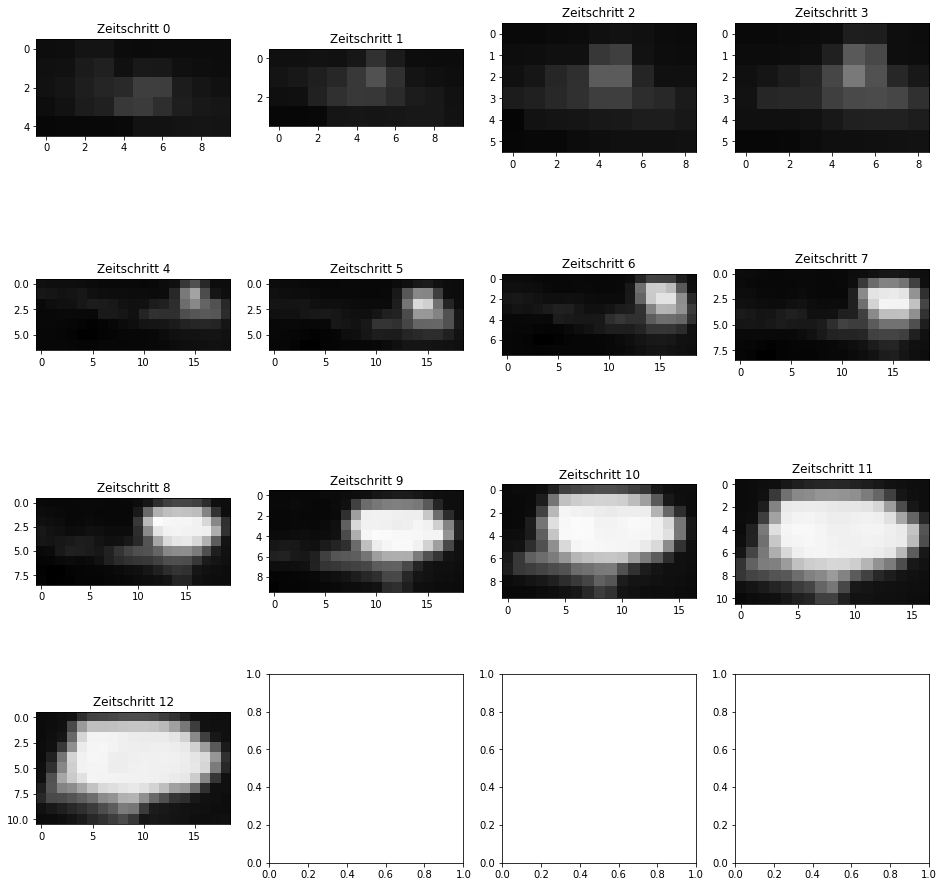

In [99]:
cutouts = []
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i in bboxes.keys():
    cutout = track_example.ir108.data[i][bboxes[i][0],bboxes[i][1]]
    
    axs[i].imshow(cutout,vmin=210,vmax=300, cmap='gray_r')
    axs[i].set_title(u"Zeitschritt {}".format(i))

In [138]:
test = np.array([ot.segment_morphological_reconstruction(d,'min',-2) for d in track_example.ir108.data])

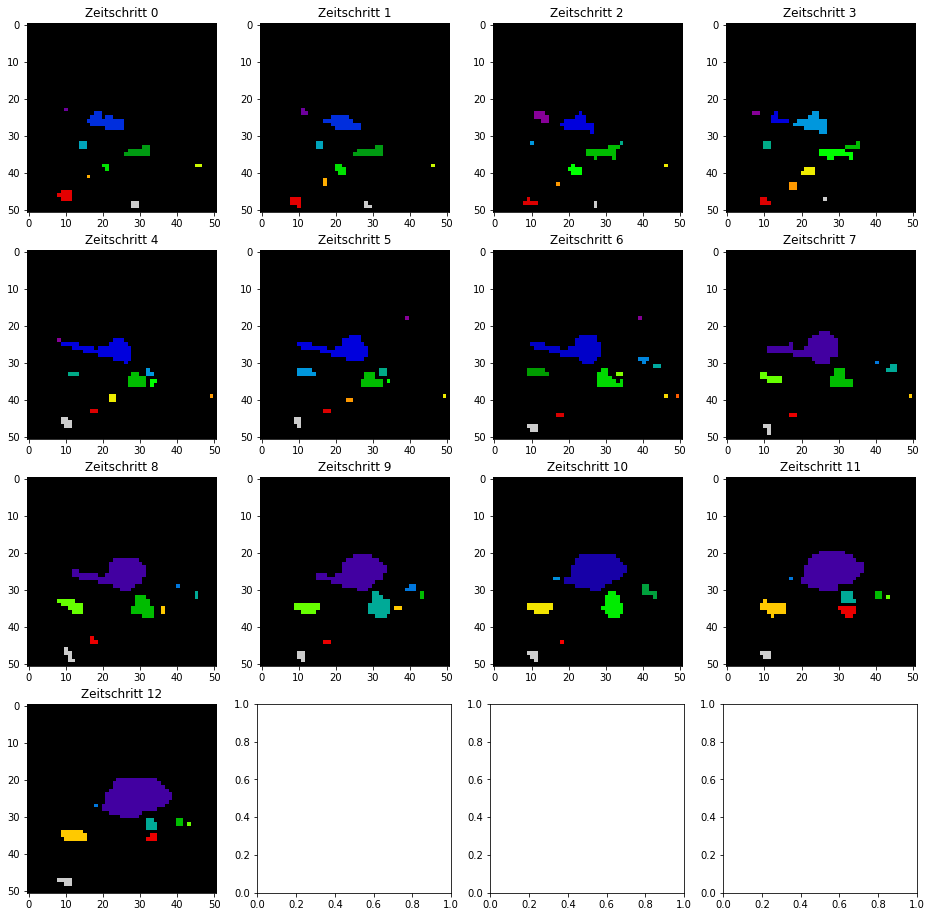

In [139]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i,t in enumerate(test):
    axs[i].imshow(t,cmap='nipy_spectral',vmin=0)
    axs[i].set_title(u"Zeitschritt {}".format(i))

In [142]:
test2 = np.array([ot.segment_morphological_reconstruction(d,'max',0.15) for d in track_example.hrv.data])

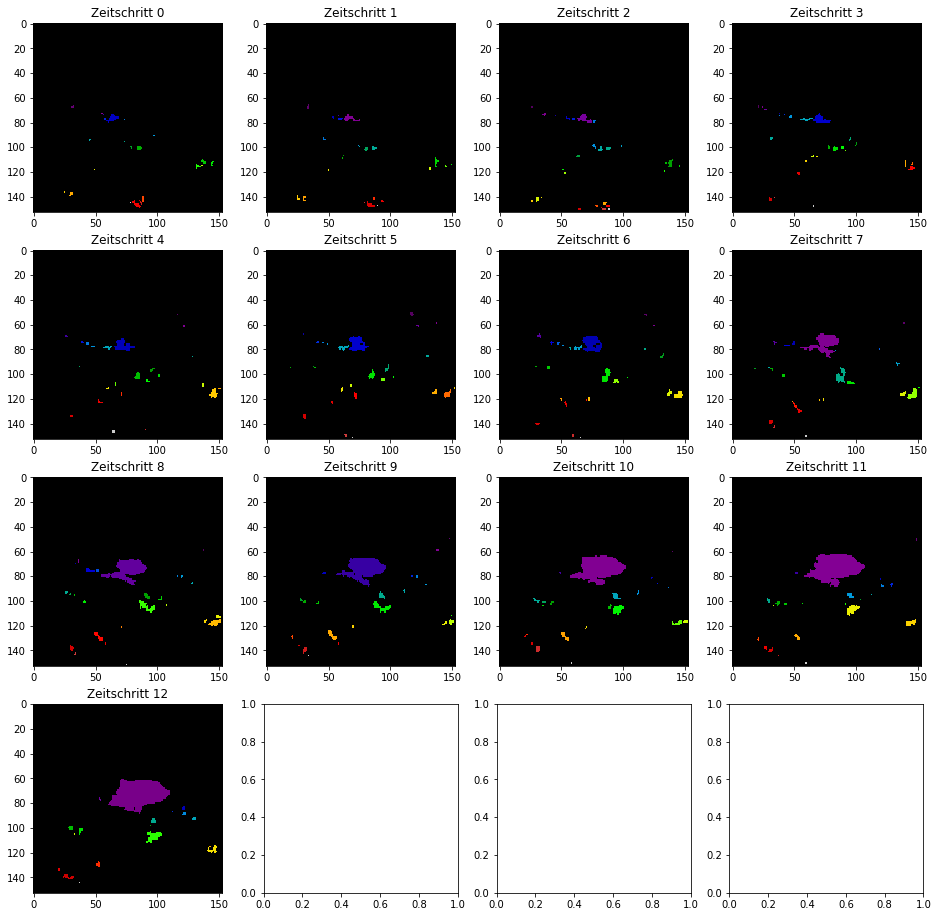

In [143]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i,t in enumerate(test2):
    axs[i].imshow(t,cmap='nipy_spectral',vmin=0)
    axs[i].set_title(u"Zeitschritt {}".format(i))

In [155]:
con, obj_hrv = ot.generate_graph_from_components(test2,np.arange(0,13,1))

In [150]:
wanted_id = []

for o in np.unique(test2[6]):
    idx = np.where(test2[6]==o)
    
    if test2[6].shape[0]//2 in idx[0] and test2[6].shape[1]//2 in idx[1]:
        wanted_id = o
    else:
        continue

In [156]:
object_id = '6_{:04d}'.format(wanted_id)

wanted_object_graph = []

for obj in obj_hrv:
    if object_id in obj.nodes():
        wanted_object_graph = obj
    else:
        continue

In [157]:
wanted_object_graph.nodes()

NodeView(('1_0002', '1_0004', '1_0005', '2_0007', '2_0006', '2_0005', '2_0003', '7_0002', '8_0003', '3_0005', '3_0009', '9_0003', '12_0001', '5_0005', '11_0002', '5_0009', '4_0004', '10_0002', '4_0008', '6_0009', '6_0008', '6_0004', '0_0005', '0_0004'))

In [160]:
object_id

'6_0004'

In [158]:
wog_time = ot.sort_graph_by_timesteps(wanted_object_graph)

In [159]:
wog_time

{0: ['0_0005', '0_0004'],
 1: ['1_0002', '1_0004', '1_0005'],
 2: ['2_0007', '2_0006', '2_0005', '2_0003'],
 3: ['3_0005', '3_0009'],
 4: ['4_0004', '4_0008'],
 5: ['5_0005', '5_0009'],
 6: ['6_0009', '6_0008', '6_0004'],
 7: ['7_0002'],
 8: ['8_0003'],
 9: ['9_0003'],
 10: ['10_0002'],
 11: ['11_0002'],
 12: ['12_0001']}

In [163]:
object_track = ot.extract_main_graph_from_complex(test2,wog_time,object_id,'size')

In [164]:
print(object_track)

['0_0004', '1_0002', '2_0003', '3_0005', '4_0004', '5_0005', '6_0004', '7_0002', '8_0003', '9_0003', '10_0002', '11_0002', '12_0001']


In [165]:
bboxes = ot.get_bounding_box(test2,object_track)

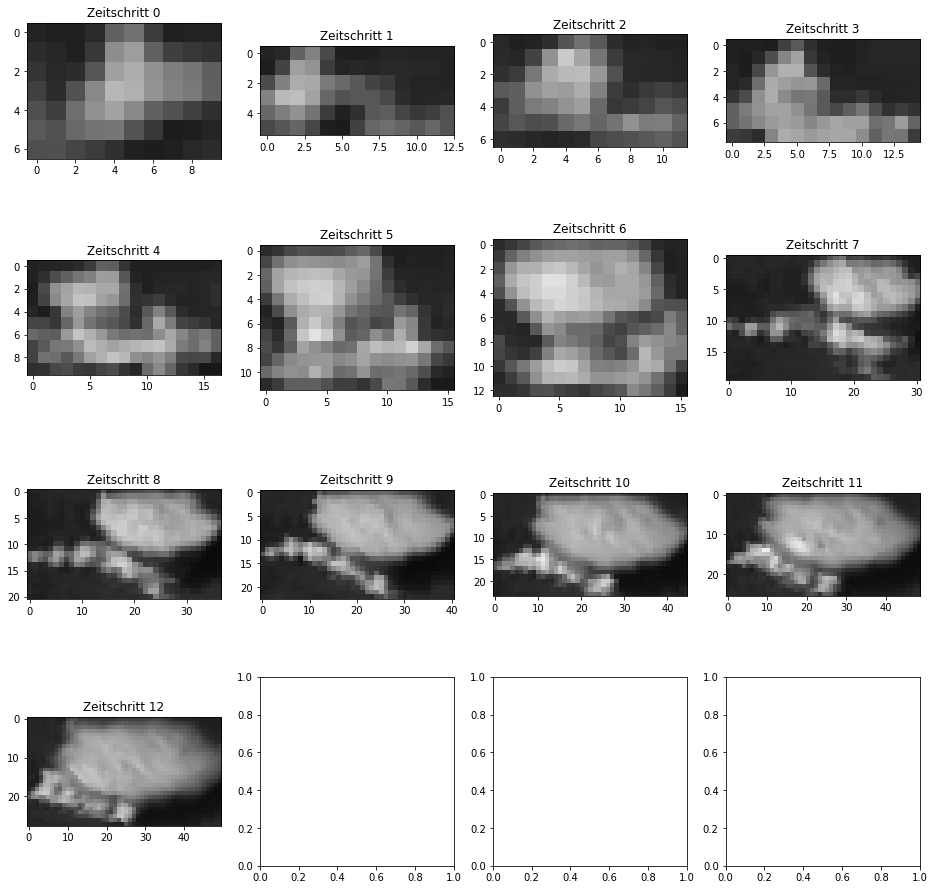

In [166]:
cutouts = []
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()
for i in bboxes.keys():
    cutout = track_example.hrv.data[i][bboxes[i][0],bboxes[i][1]]
    
    axs[i].imshow(cutout,vmin=0,vmax=1, cmap='gray')
    axs[i].set_title(u"Zeitschritt {}".format(i))

In [171]:
np.percentile(ir_holes[6],(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.99))

array([-73.29148865, -67.58697205, -61.28643494, -49.32075195,
       -39.08342896, -33.96133423, -31.35969238, -29.95455322,
       -24.44840088, -18.20280029])

In [29]:
#ndi.labeled_comprehension(track_example.hrv.data[6],
#                          hrv_peaks_masked[6],
#                          np.arange(1,np.max(hrv_peaks_masked[6]+1)),np.max, float, 0)

array([0.46495091, 0.877837  , 0.57634539, 0.3765618 , 0.74706955,
       0.63567507, 0.6017724 , 0.69863717, 0.53517787, 0.55818325])